## Case Study: The Shiller CAPE Ratio
Varvara Bondarenko\
05.03.2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

### Task 1: Forecasting real stock returns with CAPE

#### Import and prepare data

The dataset is sourced from Shiller's "US Stock Price, Earnings, and CAPE since 1871" (https://shillerdata.com/). 
The columns with real (inflation adjusted to 2025) stock prices, earnings, and other relevant numbers are selected:

In [2]:
# Import, rename, all values are real, TR for total return
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/72e3c924-5365-4103-9e3e-2a5cddfa6ac4/ie_data.xls?ver=1738768846444"

# Import relevant columns and format data frame for clarity
# Import until 2024.09 - the last date with earnings
df = pd.read_excel(url, sheet_name="Data", skiprows=7, usecols=[0, 4, 5, 7, 9, 10, 11, 19], nrows=1845)
df = df.rename(columns={
    'Fraction': 'Date Fraction',
    'Price.1': 'TR Price',
    'Earnings': 'Earnings',
    'Earnings.1': 'TR Earnings',})
df.set_index('Date', inplace=True)

df.head(1)

,CPI,Date Fraction,Price,TR Price,Earnings,TR Earnings,Real Return
Date,,,,,,,
1871.01,12.464061,1871.041667,112.456056,112.456056,10.131176,10.131176,0.130609


#### Forecast returns using CAPE and plot Predicted vs Real Returns

In [3]:
def forecast_return(price, earnings):
    """
    Compute CAPE and forecasted return.

    Parameters:
    price -- real prices for each period
    earnings -- real earnings starting 120 months (10 years) before `price`

    Returns:
    tuple:
        pd.Series: CAPE values for each month, starting from the 121st period
        pd.Series: Predicted returns based on CAPE
    """

    # Calculate cape
    rolling_earnings = earnings.rolling(120).mean()
    cape = price / rolling_earnings

    # Calculate return
    return_predicted = 0.270 - 0.177*np.log10(cape)  # formula from page 2

    return cape, return_predicted

In [4]:
# Find CAPE and Predicted Returns
df['CAPE'], df['Predicted Return'] = forecast_return(df['Price'], df['Earnings'])

# Same for total return values
df['TR CAPE'], df['TR Predicted Return'] = forecast_return(df['TR Price'], df['TR Earnings'])

display(df)

,CPI,Date Fraction,Price,TR Price,Earnings,TR Earnings,Real Return,CAPE,Predicted Return,TR CAPE,TR Predicted Return
Date,,,,,,,,,,,
1871.01,12.464061,1871.041667,112.456056,1.124561e+02,10.131176,10.131176,0.130609,NaN,NaN,NaN,NaN
1871.02,12.844641,1871.125000,110.598690,1.111312e+02,9.830995,9.878329,0.130858,NaN,NaN,NaN,NaN
1871.03,13.034972,1871.208333,111.647827,1.127127e+02,9.687447,9.779840,0.130951,NaN,NaN,NaN,NaN
1871.04,12.559226,1871.291667,119.144747,1.208309e+02,10.054409,10.196699,0.122056,NaN,NaN,NaN,NaN
1871.05,12.273812,1871.375000,125.001800,1.273360e+02,10.288214,10.480328,0.122638,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024.05,314.069000,2024.375000,5262.229282,3.498233e+06,195.975675,130280.999393,NaN,33.665346,-0.000311,36.256354,-0.006011
2024.06,314.175000,2024.458333,5441.235928,3.621239e+06,197.708181,131578.316021,NaN,34.697480,-0.002633,37.351754,-0.008299
2024.07,314.540000,2024.541667,5558.234619,3.703137e+06,198.653029,132351.262018,NaN,35.329480,-0.004020,38.014967,-0.009652


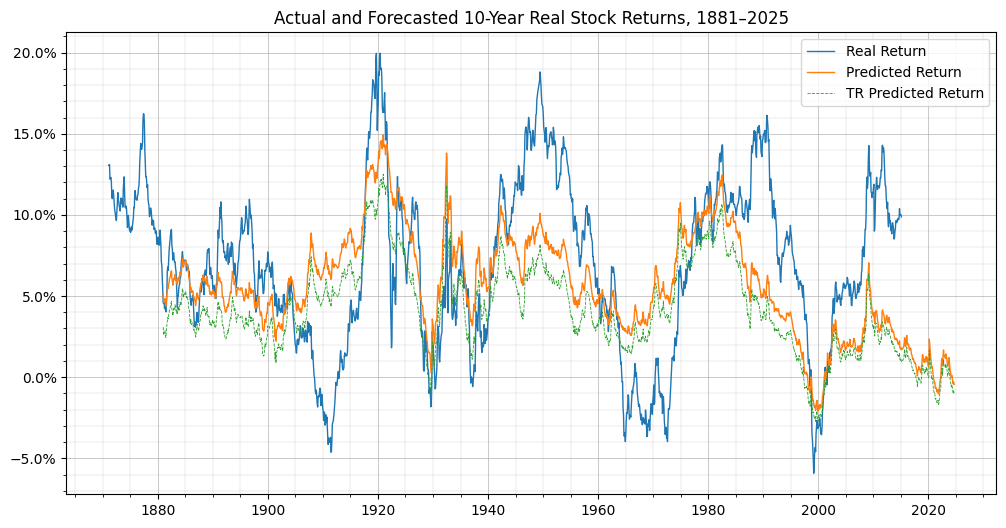

In [5]:
# Plot Real Returns and Predicted (with both normal and TR CAPE ratio) Returns 

plt.figure(figsize = (12, 6))

plt.plot(df['Date Fraction'], df['Real Return'], label = "Real Return", linewidth = 1)
plt.plot(df['Date Fraction'], df['Predicted Return'], label = "Predicted Return", linewidth = 1)
plt.plot(df['Date Fraction'], df['TR Predicted Return'],
         label = "TR Predicted Return", linestyle = "dashed", linewidth = 0.6)

# Format plot
plt.title('Actual and Forecasted 10-Year Real Stock Returns, 1881–2025')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.grid(True, which='minor', linewidth=0.3, alpha=0.6)
plt.grid(True, which='major', linewidth=0.6, alpha=0.8)
plt.minorticks_on()

### Task 2: Trading strategy using CAPE

#### Define a strategy

The strategy adjusts the portfolio’s stock allocation based on predicted returns.

In [6]:
# Function to determine position size based on returns

def get_position_size(predicted_return):
    """
    Determine the proportion of the portfolio to allocate to stocks based on the predicted return.
    
    Parameters:
    predicted_return (pd.Series): predicted returns for different periods
    
    Returns:
    pd.Series: Proportions of the portfolio to invest in stocks, ranging from 0.0 to 1.0.
    """
    if predicted_return > 0.036:
        return 1.0  # 100% invested
    elif predicted_return > 0.02:
        return 0.75  # 75% invested
    elif predicted_return > 0:
        return 0.25  # 25% invested
    else:
        return 0.0  # Exit

In [7]:
# Apply strategy to dataset to calculate the positions
df['Position Size'] = df['Predicted Return'].apply(get_position_size)  
df['Position Size Real'] = df['Real Return'].apply(get_position_size)  # Also usiing real returns for testing

#### Portfolio Initialization and Trading Simulation functions

In [8]:
# Initialize portfolio variables
def initialize_portfolio(start_date, end_date):
    """
    Create empty portfolio for the given date range.

    Parameters:
    start_date (datetime): The start date for the portfolio YYYY.MM
    end_date (datetime): The end date for the portfolio YYYY.MM

    Returns:
    pd.DataFrame: A portfolio DataFrame with filled columns:
                            'CPI', 'Date Fraction', 'Position Size', 'Position Size Real', 'TR Price',
                    and empty columns:
                            'Number of Stocks', 'Cash', 'Holdings', 'Total'
    """
    portfolio = df.loc[start_date:end_date, ['CPI', 'Date Fraction', 'Position Size',
                                             'Position Size Real', 'TR Price']].reset_index(drop=True) 

    portfolio['Number of Stocks'] = 0.
    portfolio['Cash'] = 0.
    portfolio['Holdings'] = 0.
    portfolio['Total'] = 0.

    return portfolio


# Simulate trading
def simulate_trading(portfolio, initial_capital, real_returns = False):
    """
    Simulate a trading strategy by allocating capital based returns.

    Args:
        portfolio (DataFrame): Empty portfolio with price, position size, and CPI data
        initial_capital (float): Starting cash for investment
        real_returns (bool, optional): If True, uses real returns; otherwise, predicted. False by default

    Returns:
        DataFrame: Updated portfolio with stocks, cash, holdings, total value, and returns
    """
    cash = initial_capital
    n_stocks = 0.  # Number of stocks

    for i in portfolio.index:
        # Define values for the current period
        price = portfolio.loc[i, 'TR Price']

        if real_returns == False:  # Use position size determined by predicted returns
            position_size = portfolio.loc[i, 'Position Size']
        else:  # Use position size determined by real returns
            position_size = portfolio.loc[i, 'Position Size Real']
        historical_cpi = portfolio.loc[i, 'CPI']
        current_cpi = portfolio.loc[i, 'CPI']

        # # Inflation adjustment
        # if 0 < i < portfolio.index[-1]: 
        #     next_cpi = portfolio.loc[i+1, 'CPI']
        #     cash *= next_cpi / current_cpi
        
    
        total = cash + (n_stocks * price)  # Portfolio value before rebalancing
        holdings = total * position_size  # Amount invested in stocks
        n_stocks = holdings / price  # Number of stocks
        cash = total - holdings  # Remaining cash after buying stocks
    
        # Update portfolio
        portfolio.loc[i, 'Number of Stocks'] = n_stocks
        portfolio.loc[i, 'Cash'] = cash
        portfolio.loc[i, 'Holdings'] = holdings
        portfolio.loc[i, 'Total'] = cash + holdings

    # Add portfolio monthly returns
    portfolio['Returns'] = portfolio['Total'].pct_change()

    return portfolio


#### Annualized Volatility and Return calculation functions

In [9]:
def ann_volatility(portfolio):
    """
    Calculate the annualized volatility of the portfolio.

    Parameters:
    portfolio (pd.DataFrame): DataFrame with the column 'Returns' containing the monthly returns

    Returns:
    float: The annualized volatility of the portfolio
    """
    returns = portfolio.loc[:, 'Returns']
    return returns.std() * np.sqrt(12)

def ann_return(portfolio):
    """
    Calculate the annualized return of the portfolio.

    Parameters:
    portfolio (pd.DataFrame): DataFrame with the column 'Total' containing the total portfolio value

    Returns:
    float: The annualized return of the portfolio
    """
    total_start = portfolio['Total'].iloc[0]
    total_end = portfolio['Total'].iloc[-1]
    years = len(portfolio) / 12
    
    return (total_end/total_start) ** (1 / years) - 1

#### Big historical simulation with predicted returns

In [10]:
# Define a simulation period and initial capital
start_date = 1871.01
end_date = 2025.02
initial_capital = 1000.

# Create empty portfolio
historical_portfolio = initialize_portfolio(start_date, end_date)
historical_portfolio.head(1)



# Simulate trading
historical_portfolio_sim = simulate_trading(historical_portfolio, initial_capital)

# Display results
# Display results
display(historical_portfolio_sim)

,CPI,Date Fraction,Position Size,Position Size Real,TR Price,Number of Stocks,Cash,Holdings,Total,Returns
0,12.464061,1871.041667,0.0,1.0,1.124561e+02,0.0,1.000000e+03,0.0,1.000000e+03,NaN
1,12.844641,1871.125000,0.0,1.0,1.111312e+02,0.0,1.000000e+03,0.0,1.000000e+03,0.000000
2,13.034972,1871.208333,0.0,1.0,1.127127e+02,0.0,1.000000e+03,0.0,1.000000e+03,0.000000
3,12.559226,1871.291667,0.0,1.0,1.208309e+02,0.0,1.000000e+03,0.0,1.000000e+03,0.000000
4,12.273812,1871.375000,0.0,1.0,1.273360e+02,0.0,1.000000e+03,0.0,1.000000e+03,0.000000
...,...,...,...,...,...,...,...,...,...,...
1840,314.069000,2024.375000,0.0,0.0,3.498233e+06,0.0,4.411299e+06,0.0,4.411299e+06,0.005868
1841,314.175000,2024.458333,0.0,0.0,3.621239e+06,0.0,4.411299e+06,0.0,4.411299e+06,0.000000
1842,314.540000,2024.541667,0.0,0.0,3.703137e+06,0.0,4.411299e+06,0.0,4.411299e+06,0.000000
1843,314.796000,2024.625000,0.0,0.0,3.664238e+06,0.0,4.411299e+06,0.0,4.411299e+06,0.000000


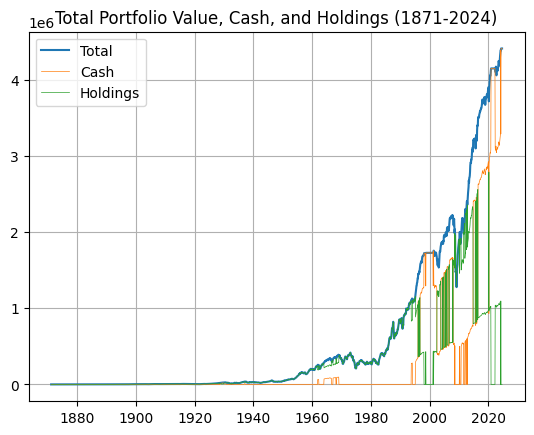

In [11]:
# Plot results
plt.plot(historical_portfolio_sim['Date Fraction'], historical_portfolio_sim['Total'], label = "Total")
plt.plot(historical_portfolio_sim['Date Fraction'], historical_portfolio_sim['Cash'], label = "Cash", linewidth = 0.5)
plt.plot(historical_portfolio_sim['Date Fraction'], historical_portfolio_sim['Holdings'], label = "Holdings", linewidth = 0.5)

plt.title('Total Portfolio Value, Cash, and Holdings (1871-2024)')
plt.legend()
plt.grid(True)

In [12]:
# Print metrics
print(f"Annualized Return: {ann_return(historical_portfolio_sim):.4%}, "
      f"Annualized Volatility: {ann_volatility(historical_portfolio_sim):.4%}")

Annualized Return: 5.6099%, Annualized Volatility: 12.7512%


#### Training set: Feb 1980 - Sep 2014 simulation

In [13]:
# Define a simulation period and capital
start_date = 1980.02
end_date = 2014.09 
initial_capital = 1000.

# Create empty portfolio
portfolio_1980_2014 = initialize_portfolio(start_date, end_date)

# Simulate trading
portfolio_1980_2014_sim = simulate_trading(portfolio_1980_2014, initial_capital)

# Display results
display(portfolio_1980_2014_sim)

,CPI,Date Fraction,Position Size,Position Size Real,TR Price,Number of Stocks,Cash,Holdings,Total,Returns
0,78.900,1980.125000,1.00,1.0,1.018638e+05,0.009817,0.000000,1000.000000,1000.000000,NaN
1,80.100,1980.208333,1.00,1.0,9.153392e+04,0.009817,0.000000,898.591093,898.591093,-0.101409
2,81.000,1980.291667,1.00,1.0,8.946838e+04,0.009817,0.000000,878.313698,878.313698,-0.022566
3,81.800,1980.375000,1.00,1.0,9.305842e+04,0.009817,0.000000,913.557162,913.557162,0.040126
4,82.700,1980.458333,1.00,1.0,9.836582e+04,0.009817,0.000000,965.660072,965.660072,0.057033
...,...,...,...,...,...,...,...,...,...,...
411,237.900,2014.375000,0.75,1.0,1.392166e+06,0.005356,2485.524474,7456.573422,9942.097896,0.008853
412,238.343,2014.458333,0.75,1.0,1.434017e+06,0.005317,2541.564307,7624.692921,10166.257227,0.022546
413,238.250,2014.541667,0.75,1.0,1.456058e+06,0.005297,2570.862660,7712.587979,10283.450638,0.011528
414,237.852,2014.625000,0.75,1.0,1.452290e+06,0.005300,2565.873213,7697.619639,10263.492852,-0.001941


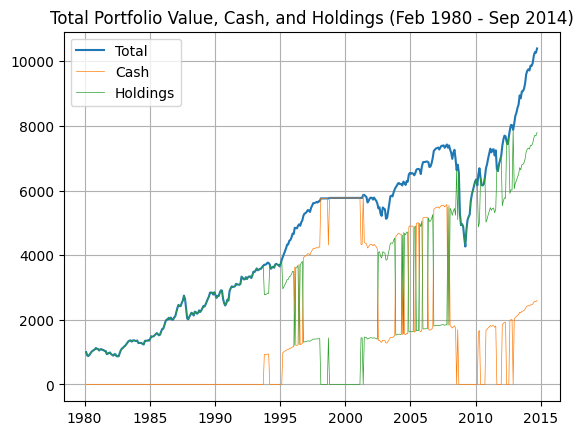

In [14]:
# Plot results
plt.plot(portfolio_1980_2014_sim['Date Fraction'], portfolio_1980_2014_sim['Total'], label = "Total")
plt.plot(portfolio_1980_2014_sim['Date Fraction'], portfolio_1980_2014_sim['Cash'], label = "Cash", linewidth = 0.5)
plt.plot(portfolio_1980_2014_sim['Date Fraction'], portfolio_1980_2014_sim['Holdings'], label = "Holdings", linewidth = 0.5)

plt.title('Total Portfolio Value, Cash, and Holdings (Feb 1980 - Sep 2014)')
plt.legend()
plt.grid(True)

In [15]:
# Print metrics
print(f"Annualized Return: {ann_return(portfolio_1980_2014_sim):.4%}, \n"
      f"Annualized Volatility: {ann_volatility(portfolio_1980_2014_sim):.4%}")

Annualized Return: 6.9870%, 
Annualized Volatility: 10.3454%


#### Sep 2014 - Sep 2024 simulation

In [16]:
# Define a simulation period and capital
start_date = 2014.09
end_date = 2024.09 
initial_capital = 1000.

# Create empty portfolio
portfolio_2014_2024 = initialize_portfolio(start_date, end_date)

# Simulate trading
portfolio_2014_2024_sim = simulate_trading(portfolio_2014_2024, initial_capital)

# Display results
display(portfolio_2014_2024_sim)

,CPI,Date Fraction,Position Size,Position Size Real,TR Price,Number of Stocks,Cash,Holdings,Total,Returns
0,238.031,2014.708333,0.75,1.0,1.477024e+06,0.000508,250.000000,750.000000,1000.000000,NaN
1,237.433,2014.791667,0.75,1.0,1.441574e+06,0.000511,245.499884,736.499653,981.999538,-0.018000
2,236.151,2014.875000,0.25,1.0,1.532118e+06,0.000168,771.193589,257.064530,1028.258118,0.047107
3,234.812,2014.958333,0.25,1.0,1.550642e+06,0.000166,773.524606,257.841535,1031.366141,0.003023
4,233.707,2015.041667,0.25,1.0,1.540708e+06,0.000167,772.285770,257.428590,1029.714360,-0.001602
...,...,...,...,...,...,...,...,...,...,...
116,314.069,2024.375000,0.00,0.0,3.498233e+06,0.000000,1417.154066,0.000000,1417.154066,0.005868
117,314.175,2024.458333,0.00,0.0,3.621239e+06,0.000000,1417.154066,0.000000,1417.154066,0.000000
118,314.540,2024.541667,0.00,0.0,3.703137e+06,0.000000,1417.154066,0.000000,1417.154066,0.000000
119,314.796,2024.625000,0.00,0.0,3.664238e+06,0.000000,1417.154066,0.000000,1417.154066,0.000000


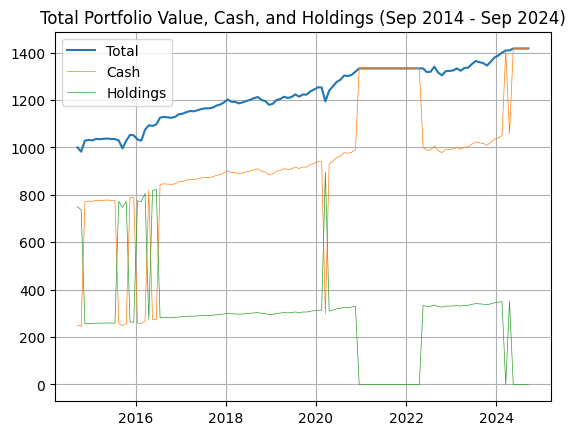

In [17]:
# Plot results
plt.plot(portfolio_2014_2024_sim['Date Fraction'], portfolio_2014_2024_sim['Total'], label = "Total")
plt.plot(portfolio_2014_2024_sim['Date Fraction'], portfolio_2014_2024_sim['Cash'], label = "Cash", linewidth = 0.5)
plt.plot(portfolio_2014_2024_sim['Date Fraction'], portfolio_2014_2024_sim['Holdings'], label = "Holdings", linewidth = 0.5)

plt.title('Total Portfolio Value, Cash, and Holdings (Sep 2014 - Sep 2024)')
plt.legend()
plt.grid(True)

In [18]:
# Print metrics
print(f"Annualized Return: {ann_return(portfolio_2014_2024_sim):.4%}, \n"
      f"Annualized Volatility: {ann_volatility(portfolio_2014_2024_sim):.4%}")

Annualized Return: 3.5182%, 
Annualized Volatility: 3.9838%


#### Feb 1990 - Sep 2024 simulation

In [19]:
# Define a simulation period and capital
start_date = 1990.09
end_date = 2024.09 
initial_capital = 1000.

# Create empty portfolio
portfolio_1990_2024 = initialize_portfolio(start_date, end_date)

# Simulate trading
portfolio_1990_2024_sim = simulate_trading(portfolio_1990_2024, initial_capital)

# Display results
display(portfolio_1990_2024_sim)

,CPI,Date Fraction,Position Size,Position Size Real,TR Price,Number of Stocks,Cash,Holdings,Total,Returns
0,132.700,1990.708333,1.0,1.0,2.563131e+05,0.003901,0.000000,1000.000000,1000.000000,NaN
1,133.500,1990.791667,1.0,1.0,2.488836e+05,0.003901,0.000000,971.013970,971.013970,-0.028986
2,133.800,1990.875000,1.0,1.0,2.557409e+05,0.003901,0.000000,997.767869,997.767869,0.027553
3,133.800,1990.958333,1.0,1.0,2.674760e+05,0.003901,0.000000,1043.551772,1043.551772,0.045886
4,134.600,1991.041667,1.0,1.0,2.640656e+05,0.003901,0.000000,1030.246157,1030.246157,-0.012750
...,...,...,...,...,...,...,...,...,...,...
404,314.069,2024.375000,0.0,0.0,3.498233e+06,0.000000,5854.280808,0.000000,5854.280808,0.005868
405,314.175,2024.458333,0.0,0.0,3.621239e+06,0.000000,5854.280808,0.000000,5854.280808,0.000000
406,314.540,2024.541667,0.0,0.0,3.703137e+06,0.000000,5854.280808,0.000000,5854.280808,0.000000
407,314.796,2024.625000,0.0,0.0,3.664238e+06,0.000000,5854.280808,0.000000,5854.280808,0.000000


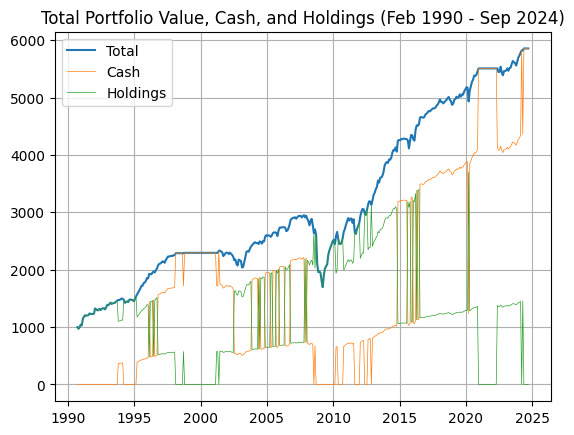

In [20]:
# Plot results
plt.plot(portfolio_1990_2024_sim['Date Fraction'], portfolio_1990_2024_sim['Total'], label = "Total")
plt.plot(portfolio_1990_2024_sim['Date Fraction'], portfolio_1990_2024_sim['Cash'], label = "Cash", linewidth = 0.5)
plt.plot(portfolio_1990_2024_sim['Date Fraction'], portfolio_1990_2024_sim['Holdings'], label = "Holdings", linewidth = 0.5)

plt.title('Total Portfolio Value, Cash, and Holdings (Feb 1990 - Sep 2024)')
plt.legend()
plt.grid(True)

In [21]:
# Print metrics
print(f"Annualized Return: {ann_return(portfolio_1990_2024_sim):.4%}, \n"
      f"Annualized Volatility: {ann_volatility(portfolio_1990_2024_sim):.4%}")

Annualized Return: 5.3216%, 
Annualized Volatility: 7.6252%
